In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
# データタイプを指定
types_dict_train = {'train_id':'int64', 'item_condition_id':'int8', 'price':'float64', 'shipping':'int8'}
types_dict_test = {'test_id':'int64', 'item_condition_id':'int8', 'shipping':'int8'}
 
# tsvファイルからPandas DataFrameへ読み込み
train_df = pd.read_csv('./data/train.tsv', sep='\t', low_memory=True, dtype=types_dict_train)
test_df = pd.read_csv('./data/test.tsv', sep='\t', low_memory=True, dtype=types_dict_test)

In [3]:
train_df.shape, test_df.shape

((1482535, 8), (693359, 7))

In [4]:
len(train_df) - train_df.count()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [5]:
len(test_df) - test_df.count()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

# データの情報

https://www.codexa.net/kaggle-mercari-price-suggestion-challenge/


- train_id / test _id – ユーザー投稿のID
- name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えています。
- item_condition_id – ユーザーが指定した商品の状態
    - 1 ~ 5っぽいけど、それぞれが何を意味しているかわからない
- category_name – 投稿カテゴリー
- brand_name – ブランドの名前
- price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなります。
- shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
- item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられています。

# category_nameを使って特徴量作成する

In [6]:
train_df['category_name'].sample(n=20, replace=False)

1241676                          Kids/Girls (4+)/Accessories
1073443                           Handmade/Clothing/Lingerie
1452968                   Other/Office supplies/Organization
1041704                               Beauty/Fragrance/Women
665403                          Kids/Toys/Novelty & Gag Toys
597880                        Sports & Outdoors/Fan Shop/NFL
1273406                      Women/Tops & Blouses/Tank, Cami
599531                                   Women/Jewelry/Rings
699095                         Men/Men's Accessories/Watches
125688     Electronics/Cell Phones & Accessories/Cell Pho...
440156                                Beauty/Fragrance/Women
1215009                         Handmade/Paper Goods/Sticker
226175                    Home/Home Décor/Home Décor Accents
1278462                      Women/Women's Accessories/Belts
1264951                                   Beauty/Makeup/Lips
1011166    Beauty/Tools & Accessories/Makeup Brushes & Tools
560674                  

- 今頃きづいたけどこれパンくずみたいな感じなのね（親子関係）

In [7]:
a = train_df['category_name'].apply(lambda x: len(str(x).split('/')))
np.unique(a, return_counts=True)

(array([1, 3, 4, 5]), array([   6327, 1471819,    1330,    3059]))

- 1,3,4,5の親子数
    - 1個の場合、3個の場合,...
- ほぼ3個が多く分布している
- 親のカテゴリ数はどんぐらいあるんじゃろうか？
- 数値に変換する場合なにでやろう
    - word2vec?

## 親カテゴリの数を調べる

In [8]:
train_df[train_df['category_name'].isnull()].shape

(6327, 8)

In [9]:
np.unique(train_df['category_name'].apply(lambda x: str(x).split('/')[0]), return_counts=True)

(array(['Beauty', 'Electronics', 'Handmade', 'Home', 'Kids', 'Men',
        'Other', 'Sports & Outdoors', 'Vintage & Collectibles', 'Women',
        'nan'], dtype=object),
 array([207828, 122690,  30842,  67871, 171689,  93680,  45351,  25342,
         46530, 664385,   6327]))

以外に少ないな。このままLabelEncoderしてもよさそう

In [10]:
train_df.loc[:, 'category_name_parent_name'] = train_df['category_name'].apply(lambda x: str(x).split('/')[0])

In [11]:
train_df.loc[train_df['category_name_parent_name'] == 'nan', 'category_name_parent_name'] = 'Nothing'

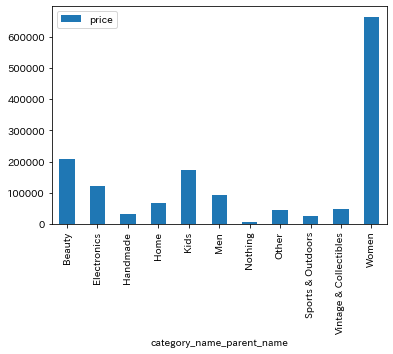

In [12]:
train_df.groupby(['category_name_parent_name'])[['price']].count().plot.bar()

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df.loc[:, 'category_name_parent_name_id'] = le.fit_transform(train_df['category_name_parent_name'])

In [14]:
le.classes_

array(['Beauty', 'Electronics', 'Handmade', 'Home', 'Kids', 'Men',
       'Nothing', 'Other', 'Sports & Outdoors', 'Vintage & Collectibles',
       'Women'], dtype=object)

関数化する

In [15]:
def add_category_name_parent_name_id(df):
    df.loc[:, 'category_name_parent_name'] = df['category_name'].apply(lambda x: str(x).split('/')[0])
    a = df['category_name_parent_name'] == 'nan'
    df.loc[a, 'category_name_parent_name'] = 'Nothing'
    
    le = LabelEncoder()
    df.loc[:, 'category_name_parent_name_id'] = le.fit_transform(df['category_name_parent_name'])
    
    return df, le

In [16]:
train_df, category_name_parent_le = add_category_name_parent_name_id(train_df)

In [17]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_parent_name,category_name_parent_name_id
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,5
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,10
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,3
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,10


In [18]:
category_name_parent_le.classes_

array(['Beauty', 'Electronics', 'Handmade', 'Home', 'Kids', 'Men',
       'Nothing', 'Other', 'Sports & Outdoors', 'Vintage & Collectibles',
       'Women'], dtype=object)

## ベクトル変換する

In [19]:
# !apt update -y

In [20]:
# !apt-get install g++ -y

In [21]:
# !pip install fasttext

In [22]:
import fasttext

In [23]:
w2v_model = fasttext.load_model('./data/wiki.en.bin')

In [24]:
w2v_model['Nothing'].shape

(300,)

In [25]:
def to_vector(words):
    vectors = np.zeros(300)
    if words == 'nan':
        vectors += w2v_model['Nothing']
        return vectors

    for word in words:
        vectors += w2v_model[word]
        
    return vectors

In [26]:
a = train_df['category_name'].sample(10, replace=False).apply(lambda x: str(x).split('/'))

In [27]:
a.apply(lambda x: to_vector(x))

860666     [-0.14240744151175022, 0.21849291771650314, -0...
686476     [-0.3449561521410942, 0.09891268878709525, 0.1...
745080     [-0.1773905772715807, 0.45718166418373585, -0....
1130531    [-0.42691485583782196, 0.23356682807207108, -0...
467798     [-0.14895984530448914, -0.06321847811341286, -...
505264     [0.2619153808336705, 0.6533122360706329, -0.83...
1147369    [0.48502910998649895, 0.8314318954944611, -1.5...
567316     [-0.26970834843814373, 0.26209963858127594, -0...
381718     [-0.25818096101284027, 0.4163813441991806, -0....
955209     [-0.0911112129688263, 0.3718097060918808, -0.9...
Name: category_name, dtype: object

In [28]:
vectors = train_df['category_name'].apply(lambda x: str(x).split('/')).apply(lambda x: to_vector(x))

In [29]:
_vectors = np.array(vectors.tolist())

In [30]:
_vectors.shape

(1482535, 300)

In [31]:
# 落ちるのでメモリ解放する
del w2v_model

In [32]:
del vectors

# 追加した特徴量を使って精度確認

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

In [34]:
x_columns = ['item_condition_id', 'shipping', 'category_name_parent_name_id']

In [35]:
x = np.concatenate([train_df[x_columns].to_numpy(), _vectors], axis=1)

In [36]:
del _vectors

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, train_df['price'], test_size=0.3, random_state=71)

In [38]:
lr_model = LinearRegression(normalize=True)
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [54]:
def evaluate(model, x, y):
    predicted = model.predict(x)
    predicted[predicted < 0] = 0
    return mean_squared_log_error(y_pred=predicted, y_true=y)

In [55]:
evaluate(lr_model, X_train, y_train)

0.5356234139209705

In [56]:
evaluate(lr_model, X_test, y_test)

0.5383875837479275

# ランダムシードを変更して試す

In [57]:
for random_state in np.random.randint(1, 1000, 3):
    X_train, X_test, y_train, y_test = train_test_split(x, train_df['price'], test_size=0.3, random_state=random_state)
    lr_model = LinearRegression(normalize=True)
    lr_model.fit(X_train, y_train)
    print(evaluate(lr_model, X_train, y_train), evaluate(lr_model, X_test, y_test))

0.5346661344864044 0.5353830262627702
0.5364690434189214 0.53561761768157
0.5364747340107241 0.5353011621483017


## モデルを変えてみる

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x, train_df['price'], test_size=0.3, random_state=71)

In [61]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=2, random_state=71, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=71, verbose=0,
                      warm_start=False)

In [62]:
 print(evaluate(rf_model, X_train, y_train), evaluate(rf_model, X_test, y_test))

0.5723257000229554 0.5740904179790538


ぐぬぬ

あとめっちゃ時間かかった